In [6]:
datasetName = 'SpinalCord_SpinalCord_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/SpinalCord_SpinalCord_Guo2020")

In [7]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [8]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalSpinalCord_1.CGAGTAGCCCTCCTCGCA,FetalSpinalCord_1.ACGTTGGCCCTCTAAGGG,FetalSpinalCord_1.ACGTTGTTTAGGCGAGTA,FetalSpinalCord_1.CATCCCCGTATTAACGCC,FetalSpinalCord_1.GAACGCGAGATCGTTGCC
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A1CF,0,1,0,0,0
A2M,0,10,1,0,0
A2MP1,0,0,0,0,0
A4GALT,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalSpinalCord_1.CGAGTAGCCCTCCTCGCA,spinal cord,FetalSpinalCord,FetalSpinalCord,normal,Donor8,male,13 weeks old
FetalSpinalCord_1.ACGTTGGCCCTCTAAGGG,spinal cord,FetalSpinalCord,FetalSpinalCord,normal,Donor8,male,13 weeks old
FetalSpinalCord_1.ACGTTGTTTAGGCGAGTA,spinal cord,FetalSpinalCord,FetalSpinalCord,normal,Donor8,male,13 weeks old
FetalSpinalCord_1.CATCCCCGTATTAACGCC,spinal cord,FetalSpinalCord,FetalSpinalCord,normal,Donor8,male,13 weeks old
FetalSpinalCord_1.GAACGCGAGATCGTTGCC,spinal cord,FetalSpinalCord,FetalSpinalCord,normal,Donor8,male,13 weeks old


[1] Erythroid progenitor cell (RP high) Sinusoidal endothelial cell        
[3] Erythroid cell                      Erythroid progenitor cell (RP high)
[5] Erythroid progenitor cell (RP high)
35 Levels: Antigen presenting cell (RPS high) Astrocyte ... T cell

In [9]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


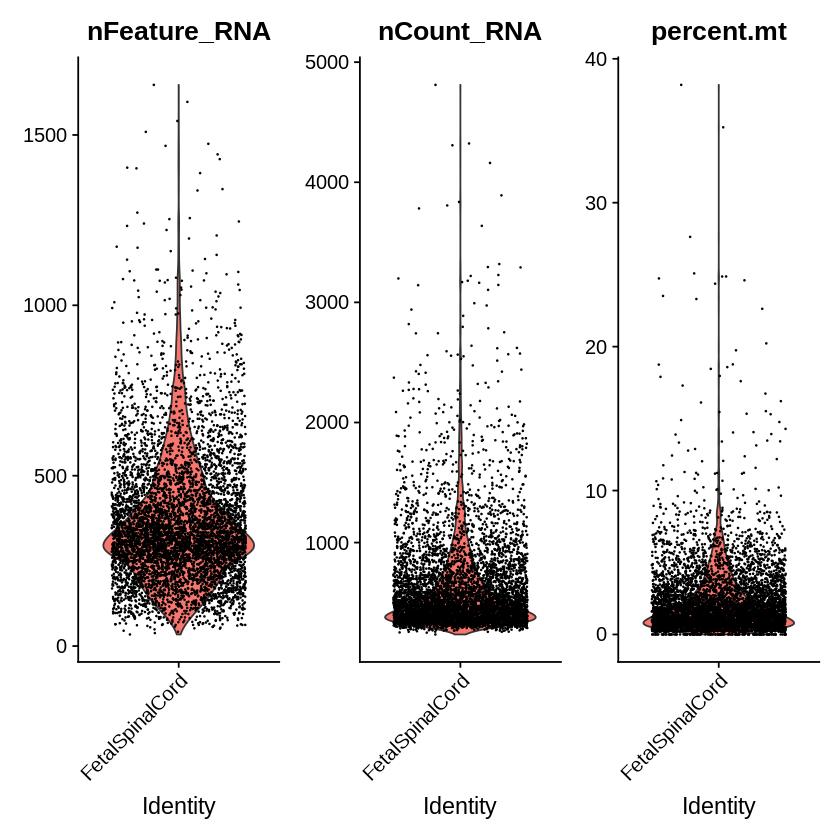

In [10]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [11]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [12]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [13]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  SPP1, CTSB, LGMN, A2M, CD14, FCER1G, C1QA, C1QB, RNASE1, DAB2 
	   S100A11, VIM, CD163, ZFP36L1, PSAP, C1QC, B2M, LYVE1, TYROBP, LGALS1 
	   ITM2B, HLA-B, MS4A7, SAT1, SEPP1, IFITM3, KCTD12, FTL, CTSS, F13A1 
Negative:  RPL21, RPS29, RPS27A, RPS3A, RPS27, RPS6, RPL34, RPS23, RPL7, RPL31 
	   RPS18, RPL37A, RPL32, RPS3, RPS14, RPL35A, RPL37, RPS17, RPS19, RPS15A 
	   RPL27A, RPS25, RPS13, RPL11, RPS24, RPL41, RPL36, RPS21, RPL30, RPL27 
PC_ 2 
Positive:  SRGN, ARHGDIB, RPLP1, AIF1, LYZ, PLAC8, MPO, PRTN3, AZU1, MS4A3 
	   VAMP8, CSTA, CTSG, RPS6, RPS29, RNASE2, RPL37, RPS20, DEFA4, RETN 
	   ELANE, S100A4, RPS23, SERPINB1, RPL27A, RPS27, DEFA3, RPS15A, RNASE3, HCST 
Negative:  STMN2, TUBA1A, GAP43, CALM2, UCHL1, RGS5, NPY, TMSB10, STMN1, RTN1 
	   LINC00682, TUBB2B, TUBB2A, ACAT2, CHGB, PCP4, GNG3, RGS4, SOX4, ENO2 
	   PRPH, MEG3, TAGLN3, SCG2, DPYSL3, NSG1, HMGCS1, NRCAM, ALCAM, GAL 
PC_ 3 
Positive:  AHSP, HBA1, HBA2, GYPA, HBG1, GYPB, HBM, BLVRB, HEMGN, HBB 
	   PR

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


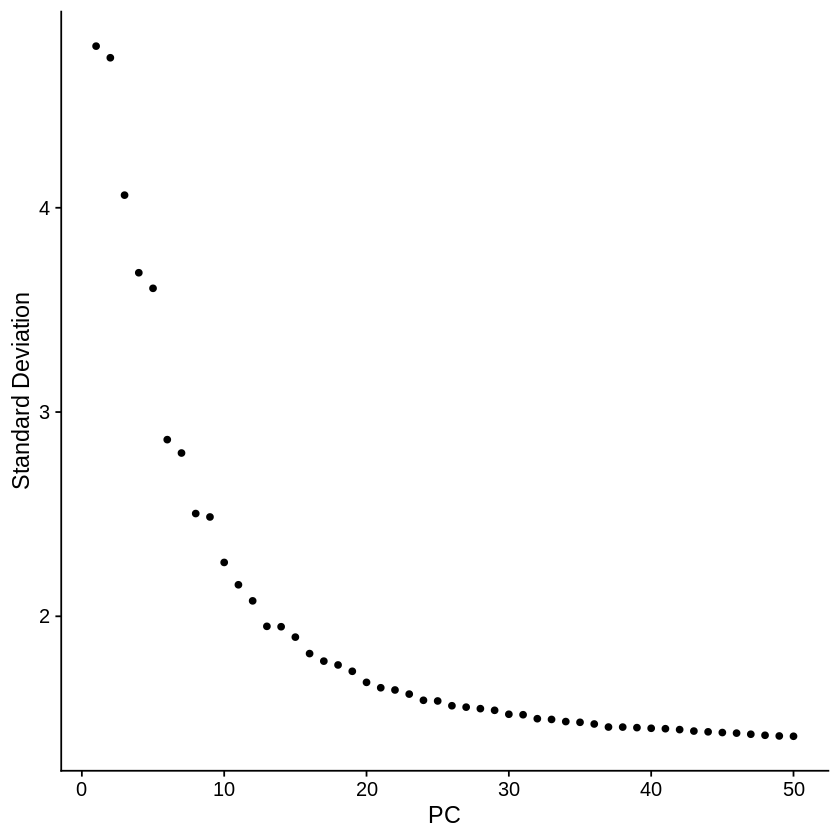

In [14]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [15]:
dev.off()
pcDim = 15 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
06:10:43 UMAP embedding parameters a = 0.9922 b = 1.112

06:10:43 Read 4483 rows and found 15 numeric columns

06:10:43 Using Annoy for neighbor search, n_neighbors = 30

06:10:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:10:44 Writing NN index file to temp file /tmp/RtmpG6FScS/file55836dbcd3db

06:10:44 Searching Annoy index using 1 thread, search_k = 3000

06:10:45 Annoy recall = 100%

06:10:45 Commencing smooth kNN distance calibration using 1 thread

06:10:46 Initializing fro

In [16]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4483
Number of edges: 155600

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8752
Number of communities: 14
Elapsed time: 0 seconds


06:10:59 UMAP embedding parameters a = 0.9922 b = 1.112

06:10:59 Read 4483 rows and found 15 numeric columns

06:10:59 Using Annoy for neighbor search, n_neighbors = 30

06:10:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

06:10:59 Writing NN index file to temp file /tmp/RtmpG6FScS/file55836d07e91e

06:10:59 Searching Annoy index using 1 thread, search_k = 3000

06:11:00 Annoy recall = 100%

06:11:01 Commencing smooth kNN distance calibration using 1 thread

06:11:01 Initializing from normalized Laplacian + noise

06:11:01 Commencing optimization for 500 epochs, with 191382 positive edges

06:11:12 Optimization finished



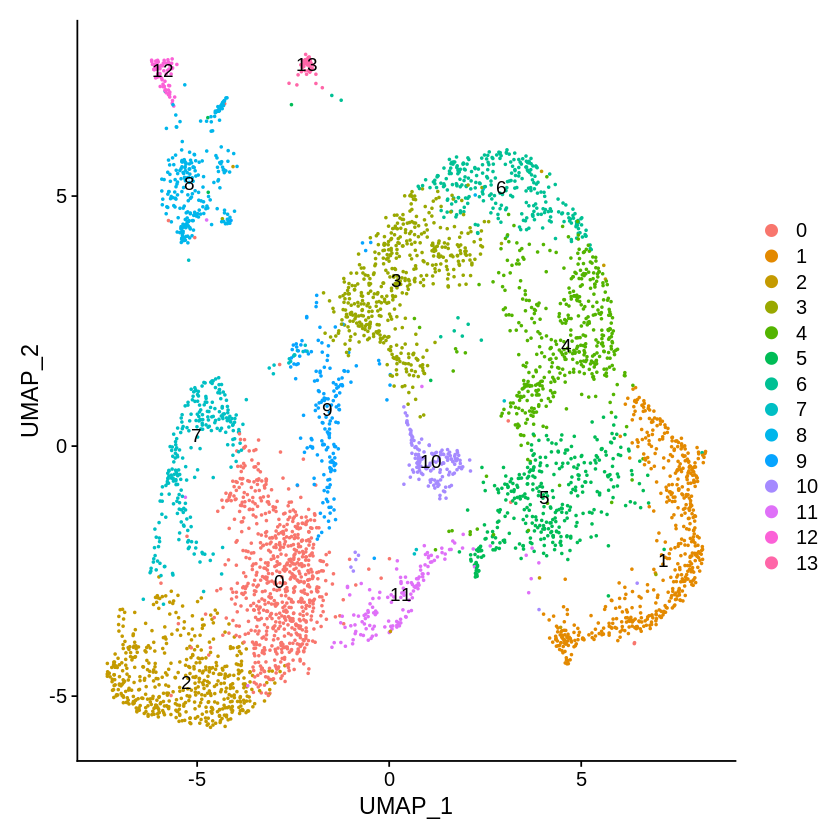

In [17]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [13]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

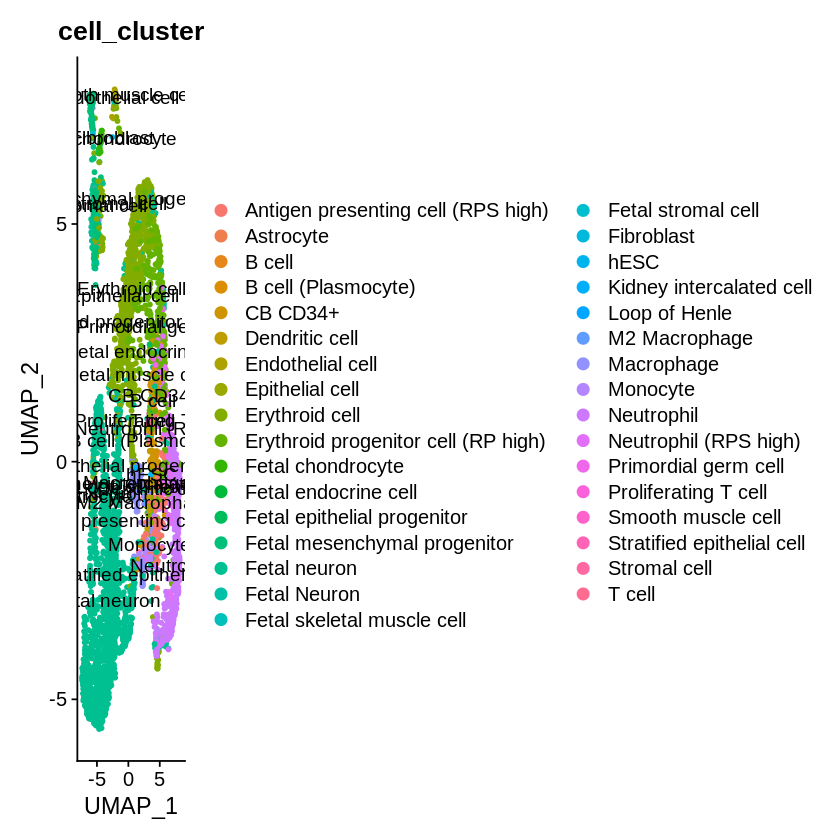

In [19]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) #+ NoLegend()
p_umap2

In [15]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [16]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [17]:
new.cluster.ids <- c('Spinal cord-Nerve tissue-Sympathetic neuron-NPY', 'Spinal cord-Nerve tissue-Sympathetic neuron-NPY', 'Spinal cord-Connective tissue-Erythrocyte-HBA1',
                    'Unknown', 'Spinal cord-Connective tissue-Neutrophil-MPO', 'Spinal cord-Connective tissue-Neutrophil-DEFA4', 
                    'Spinal cord-Connective tissue-Erythrocyte-HBA1', 'Spinal cord-Nerve tissue-Motor neuron-C1orf61', 'Spinal cord-Connective tissue-Fibroblast-DCN',
                    'Spinal cord-Connective tissue-Erythrocyte-HBA1', 'Spinal cord-Connective tissue-Neutrophil-DEFA4', 'Spinal cord-Connective tissue-Macrophage-RNASE1',
                    'Spinal cord-Nerve tissue-Sympathetic neuron-NPY', 'Spinal cord-Connective tissue-Fibroblast-DCN', 'Spinal cord-Epithelial tissue-Vascular epithelial cell-PLVAP')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

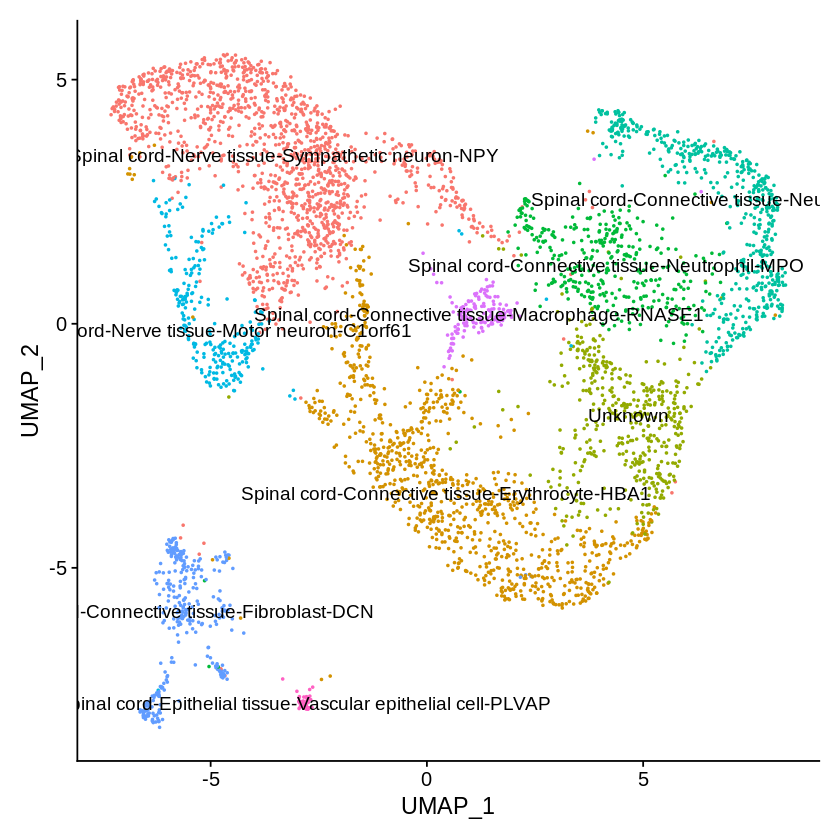

In [18]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [19]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [20]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))